In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.patches as mpatches
import scipy.stats as st
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import cluster
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [11]:
data = pd.read_csv('notes.csv')

In [12]:
data

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...,...
165,False,172.11,104.23,104.45,5.24,3.58,111.78
166,False,173.01,104.59,104.31,5.04,3.05,110.91
167,False,172.47,104.27,104.10,4.88,3.33,110.68
168,False,171.82,103.97,103.88,4.73,3.55,111.87


## Brève analyse des données (univariée et bivariée)

In [13]:
data.duplicated().sum()

0

#### Pas de doublons pour notre dataframe.

In [14]:
display(data[data<0].count())

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

#### Pas de valeurs négatives non plus.

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    170 non-null    bool   
 1   diagonal      170 non-null    float64
 2   height_left   170 non-null    float64
 3   height_right  170 non-null    float64
 4   margin_low    170 non-null    float64
 5   margin_up     170 non-null    float64
 6   length        170 non-null    float64
dtypes: bool(1), float64(6)
memory usage: 8.3 KB


#### Pas de valeurs nulles.

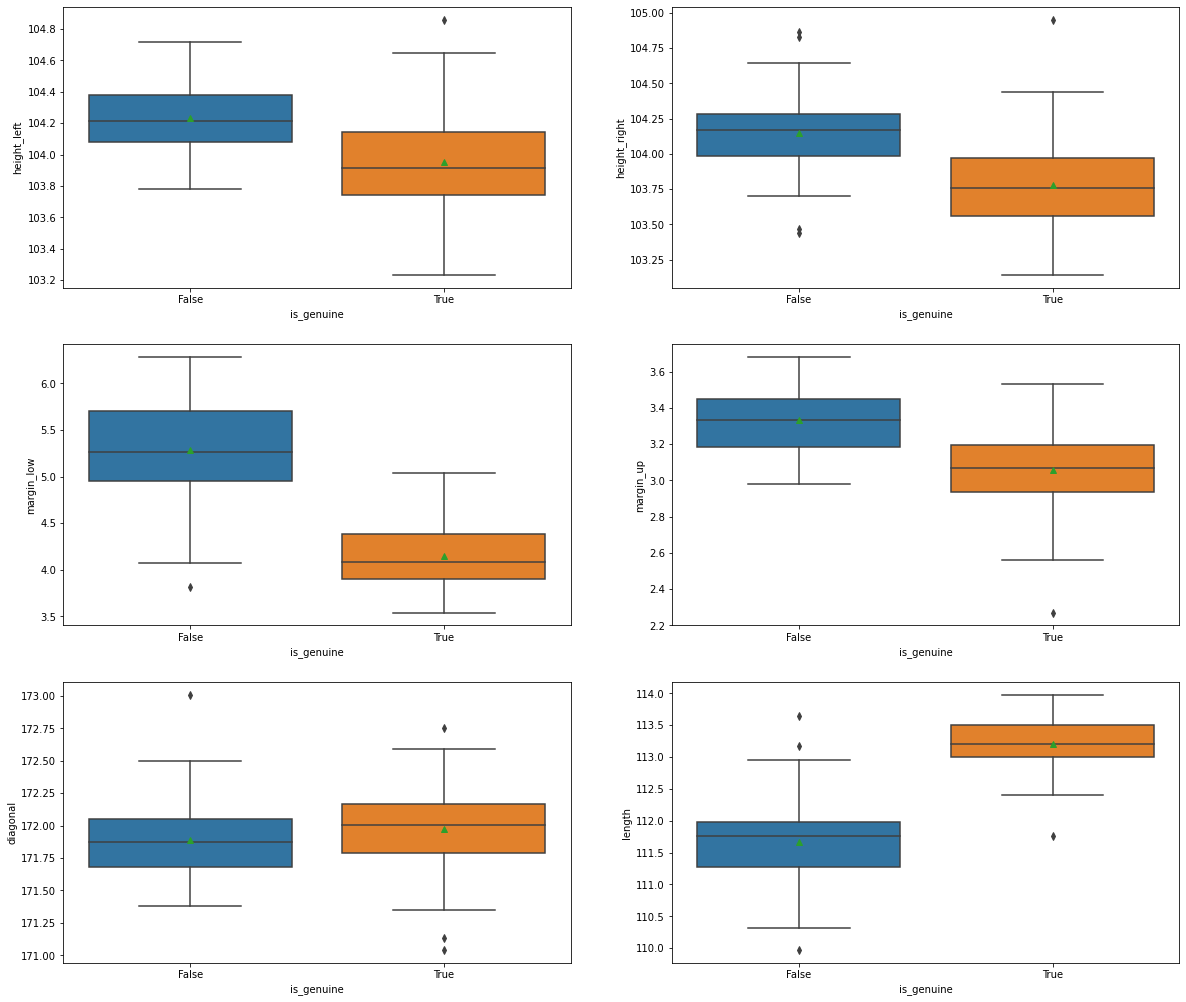

In [16]:
plt.figure(figsize=(20, 30))

plt.subplot(521)
sns.boxplot(x='is_genuine', y='height_left', data=data, showmeans=True)
plt.subplot(522)
sns.boxplot(x='is_genuine', y='height_right', data=data, showmeans=True)
plt.subplot(523)
sns.boxplot(x='is_genuine', y='margin_low', data=data, showmeans=True)
plt.subplot(524)
sns.boxplot(x='is_genuine', y='margin_up', data=data, showmeans=True)
plt.subplot(525)
sns.boxplot(x='is_genuine', y='diagonal', data=data, showmeans=True)
plt.subplot(526)
sns.boxplot(x='is_genuine', y='length', data=data, showmeans=True)

plt.savefig("p6_graphic/boxplot_2.png")
plt.show()

In [17]:
c = data.groupby(by='is_genuine').mean()
c

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
False,171.889857,104.230429,104.145571,5.281571,3.334571,111.660714
True,171.976100,103.951500,103.775900,4.143500,3.055500,113.207200


#### Les boxplot nous permettent d'observer rapidement les différences entre les vrais et faux billets, nous pouvons ici avancer plusieurs hypothèses, à savoir que:
#### Les vrais billets semblent avoir une marge et une hauteur moins grande que les faux billets. Leurs médianes et moyennes constatent cette observation.
#### Les vrais billets sont plus longs que les faux billets, en attestent leurs médianes et moyennes.

In [18]:
#Représentation des effectifs par type de billet vrai/faux(méthode utilisée .value_counts())
effectif = data['is_genuine'].value_counts()
modalite = effectif.index #l'index de 'effectifs' contient les modalités

tab = pd.DataFrame(modalite, columns = ['is_genuine']) #création du tableau à partir des modalités
tab["n"] = effectif.values
tab["f"] = tab["n"] / len(data) #len(data) renvoie la taille de l'échantillon
tab

,is_genuine,n,f
0,True,100,0.588235
1,False,70,0.411765


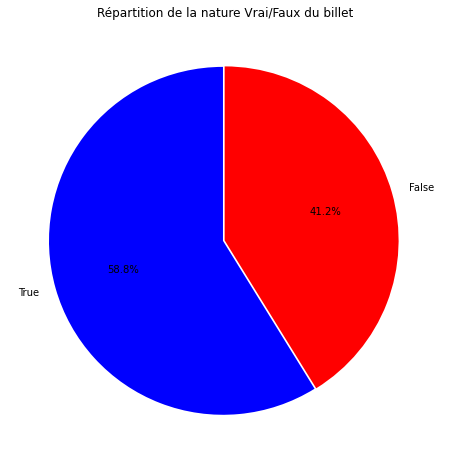

In [30]:
#Création d'un Pie Chart pour représenter la part de chaque type de billet
labels = 'True', 'False'
sizes = tab['f']
explode = (0.01, 0)

fig1, ax = plt.subplots(figsize=(8,8))
ax.pie(sizes, explode=explode, labels=labels, colors=['blue','red'], 
        autopct='%1.1f%%', startangle=90)


plt.title('Répartition de la nature Vrai/Faux du billet')

plt.savefig("p6_graphic/piechart.png")
plt.show()

In [31]:
data.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,171.940588,104.066353,103.928118,4.612118,3.170412,112.570412
std,0.305768,0.298185,0.330980,0.702103,0.236361,0.924448
min,171.040000,103.230000,103.140000,3.540000,2.270000,109.970000
25%,171.730000,103.842500,103.690000,4.050000,3.012500,111.855000
50%,171.945000,104.055000,103.950000,4.450000,3.170000,112.845000
75%,172.137500,104.287500,104.170000,5.127500,3.330000,113.287500
max,173.010000,104.860000,104.950000,6.280000,3.680000,113.980000


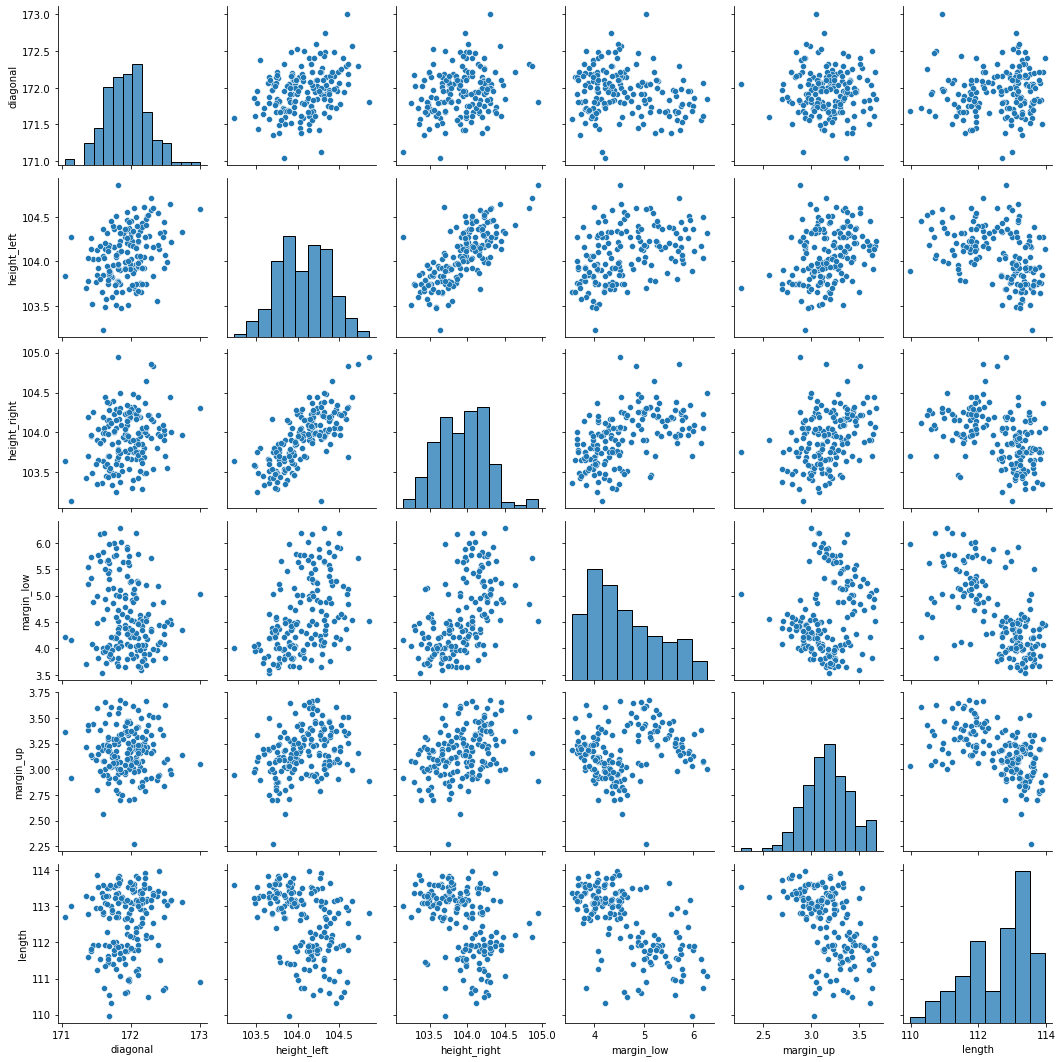

In [32]:
#Visualisation exploratoire des 6 variables quantitatives
sns.pairplot(data.iloc[:, 1:])

plt.savefig("p6_graphic/pairplot.png")
plt.show()

#### Ces graphiques nous permettent d'une part de constater les distributions de chaque variable. Et aussi d'observer des corrélations linéaires entre quelques variables. Nous allons vérifier ces observations en affichant ci-dessous les coefficients de Pearson dont la p-valeur est inférieure à 5%, ce qui implique une corrélation significative entre 2 variables.

In [33]:
def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = st.pearsonr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix

In [34]:
def plot_cor_matrix(corr, mask=None):
    f, ax = plt.subplots(figsize=(15, 10))
    sns.heatmap(corr, ax=ax,
                mask=mask,
                # cosmetics
                annot=True, vmin=-1, vmax=1, center=0,
                cmap='coolwarm', linewidths=2, linecolor='black', cbar_kws={'orientation': 'horizontal'})

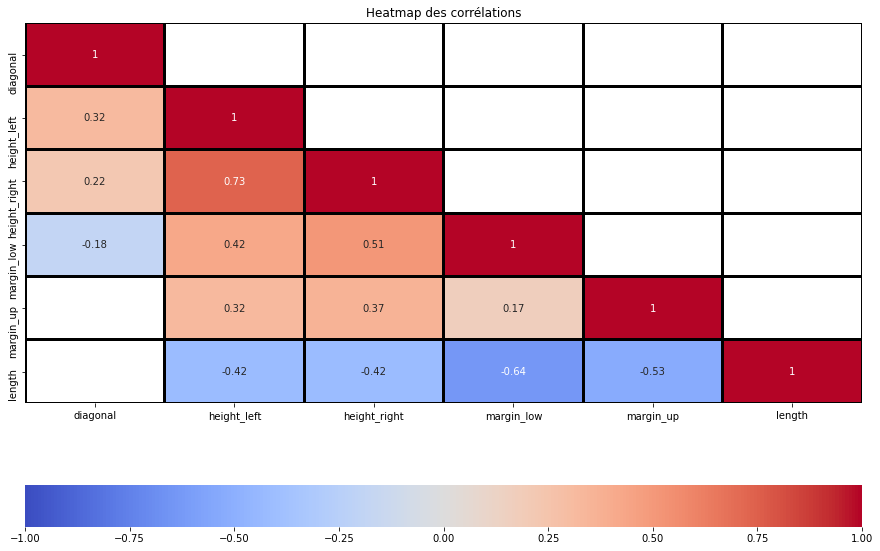

In [35]:
# Plotting with significance filter
corr = data.iloc[:, 1:].corr()                           # get correlation
p_values = corr_sig(data.iloc[:, 1:])                     # get p-Value
mask = np.invert(np.tril(p_values<0.05))    # mask - only get significant corr
plot_cor_matrix(corr, mask) 
plt.title('Heatmap des corrélations')

plt.savefig("p6_graphic/heatmap.png")
plt.show()

#### Cette Heatmap représente tous les coefficients de Pearson dont la corrélation est significative (p-value<5%). Nous remarquons que la longueur est anti-corrélée à la marge et la hauteur.
#### Corrélation forte entre les variables "height_right" et "height_left".
#### La marge semble plutôt corrélée à la hauteur du billet en général.

## Analyse en composante principales (ACP) de l'échantillon.

In [36]:
df = data.copy()
df.set_index('is_genuine', inplace=True)
df

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
True,171.81,104.86,104.95,4.52,2.89,112.83
True,171.67,103.74,103.70,4.01,2.87,113.29
True,171.83,103.76,103.76,4.40,2.88,113.84
True,171.80,103.78,103.65,3.73,3.12,113.63
True,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...
False,172.11,104.23,104.45,5.24,3.58,111.78
False,173.01,104.59,104.31,5.04,3.05,110.91
False,172.47,104.27,104.10,4.88,3.33,110.68


In [1]:
X = df.values # Transformation des données en numpy array
std_scale = preprocessing.StandardScaler().fit(X) # centrage
X_scaled = std_scale.transform(X) # réduction

NameError: name 'data_cl6' is not defined

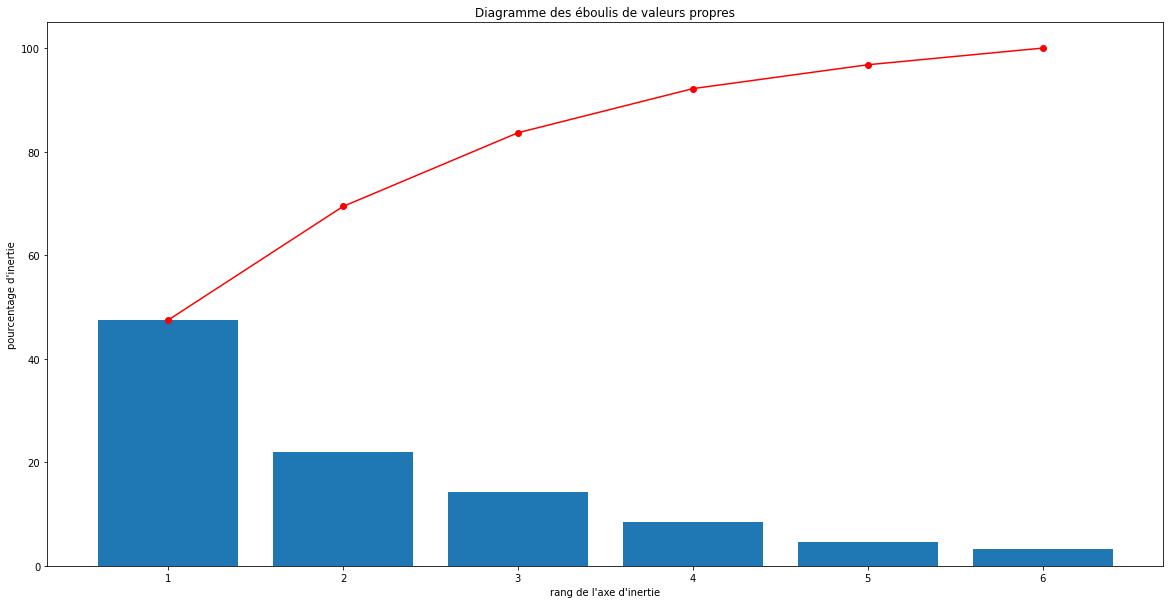

In [38]:
#Représentation de la variance expliquée: Diagramme des éboulis de valeurs propres avec somme cumulée
pca = decomposition.PCA()
pca.fit(X_scaled)
scree = pca.explained_variance_ratio_*100

plt.figure(figsize=(20,10))
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(), c='red',marker='o')
    
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Diagramme des éboulis de valeurs propres")

plt.savefig("p6_graphic/eboulis_valeurs_propres.png")
plt.show()

#### La méthode du coude précise une représentation satisfaisante de nos variables sur les deux premières composantes principales, le premier axe factoriel.

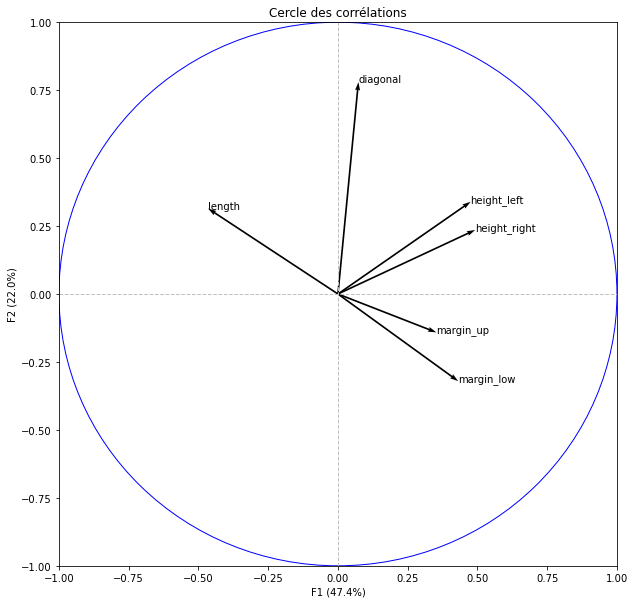

In [39]:
#Cercle des corrélations des variables
pcs = pca.components_

fig = plt.subplots(figsize=(10,10))
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
           pcs[0,:], pcs[1,:], angles='xy', scale_units='xy', scale=1, color='black', width= 0.003)

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    plt.text(x, y, df.columns[i])
    
circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
plt.gca().add_artist(circle)

# Ajout des axes
plt.plot([-1,1],[0,0],color='silver',linestyle='--',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='--',linewidth=1)

plt.title('Cercle des corrélations')
plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))

plt.savefig("p6_graphic/cercle_correlation.png")
plt.show()

#### F1 représente ici la longueur et la hauteur du billet, ainsi que la marge.
#### F2 représente la longueur de la diagonale du billet.

In [40]:
X_projected = pca.transform(X_scaled)
df_facto = pd.DataFrame(X_projected, index=data.index, columns=["F" + str(i+1) for i in range(6)]).iloc[:, :2]
df_facto

,F1,F2
0,2.153639,1.599709
1,-2.110416,-0.526039
2,-1.973152,-0.048102
3,-2.059795,-0.089105
4,-2.403180,0.412170
...,...,...
165,2.478626,0.189974
166,2.585331,2.914472
167,2.067245,0.845602
168,0.739257,-0.972965


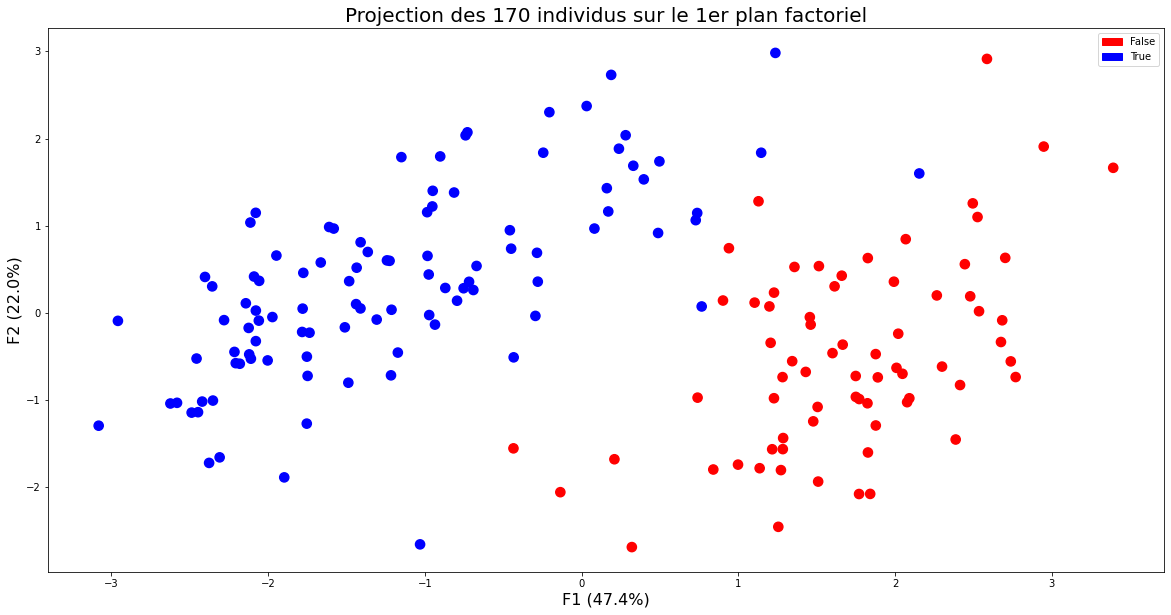

In [41]:
plt.figure(figsize=(20, 10))

#Projection des individus par scatter Plot sur le premier plan factoriel
colors = ['red', 'blue']
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=data['is_genuine'].apply(lambda x: colors[x]), 
            linewidths=1.4, s=85)

#Labels de la nature des billets
lab_0 = mpatches.Patch(color='red', label='False')
lab_1 = mpatches.Patch(color='blue', label='True')
plt.legend(handles=[lab_0, lab_1])

plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)), fontsize=16)
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)), fontsize=16)
plt.title("Projection des 170 individus sur le 1er plan factoriel", fontsize=20)

plt.savefig("p6_graphic/projection_pca.png")
plt.show()

#### Nous pouvons observer que 2 groupes de billets sont pratiquement séparés par une diagonale.

## Qualité des représentations  des individus.

In [42]:
#Qualité de représentation des individus - COS2
di = np.sum(X_scaled**2,axis=1)
cos2 = X_projected**2
n_comp = 2

for j in range(n_comp):
    cos2[:,j] = cos2[:,j]/di
    
cos2_indiv = pd.DataFrame({'COS2_1':cos2[:,0],'COS2_2':cos2[:,1], 'is_genuine': data['is_genuine']})
cos2_indiv

,COS2_1,COS2_2,is_genuine
0,0.251929,0.139000,True
1,0.818002,0.050822,True
2,0.784862,0.000466,True
3,0.882856,0.001652,True
4,0.320145,0.009417,True
...,...,...,...
165,0.800651,0.004703,False
166,0.324059,0.411824,False
167,0.498809,0.083461,False
168,0.156908,0.271800,False


#### Lorsque l’angle est proche de 0, c'est-à-dire que le cosinus est proche de 1, l’individu est bien représenté.

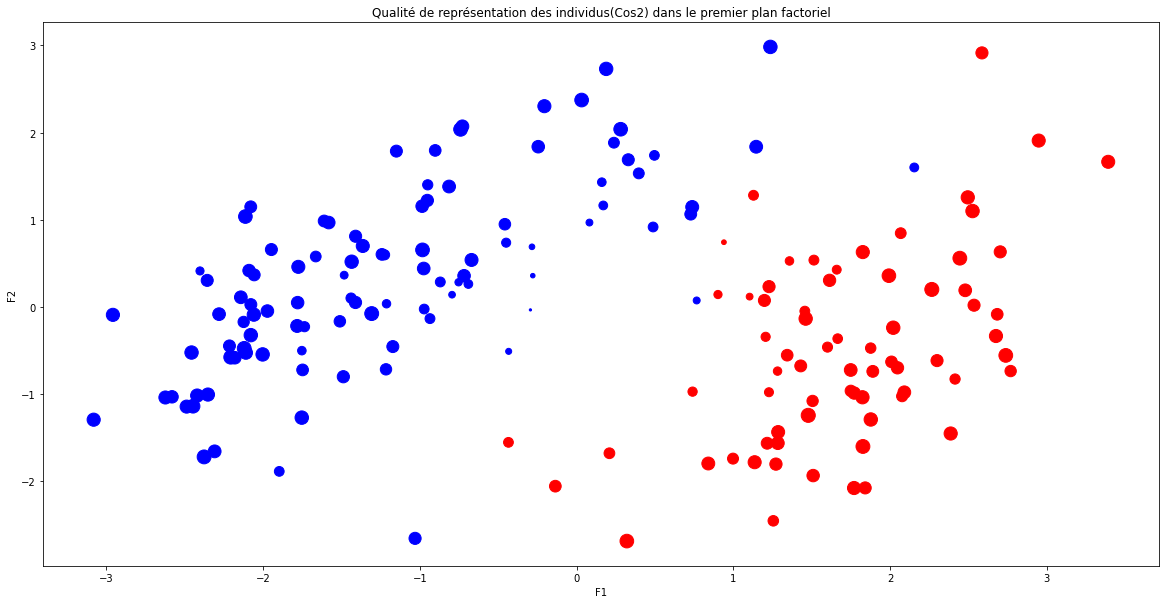

In [43]:
#Scatter Plot de la qualité de représentation des individus dans le 1er plan factoriel
plt.figure(figsize=(20, 10))
cos2_indiv['COS2_1 + COS2_2'] = cos2_indiv['COS2_1'] + cos2_indiv['COS2_2']
colors = ['red', 'blue']
plt.scatter(df_facto['F1'], df_facto['F2'], c=data['is_genuine'].apply(lambda x: colors[x]), 
            linewidths=1, s=cos2_indiv['COS2_1 + COS2_2']*200)

plt.xlabel('F1')
plt.ylabel('F2')
plt.title('Qualité de représentation des individus(Cos2) dans le premier plan factoriel')

plt.savefig('p6_graphic/qualite_representationcos2.png')
plt.show()

#### Ce graphique nous démontre que les individus sont bien représentés. En effet, un individu mal représenté sera proche de l'origine, avec par conséquent peu de contribution à la formation des axes étudiés. Nous distinguons parfaitement deux groupes d'individus.

## Contribution des individus dans l'inertie totale.

In [44]:
#Contribution des individus dans l'inertie totale

ctr_indiv_inertie = pd.DataFrame({'c_inertie':di, 'is_genuine':df.index})
ctr_indiv_inertie

,c_inertie,is_genuine
0,18.410598,True
1,5.444799,True
2,4.960527,True
3,4.805719,True
4,18.039567,True
...,...,...
165,7.673233,False
166,20.625650,False
167,8.567410,False
168,3.482926,False


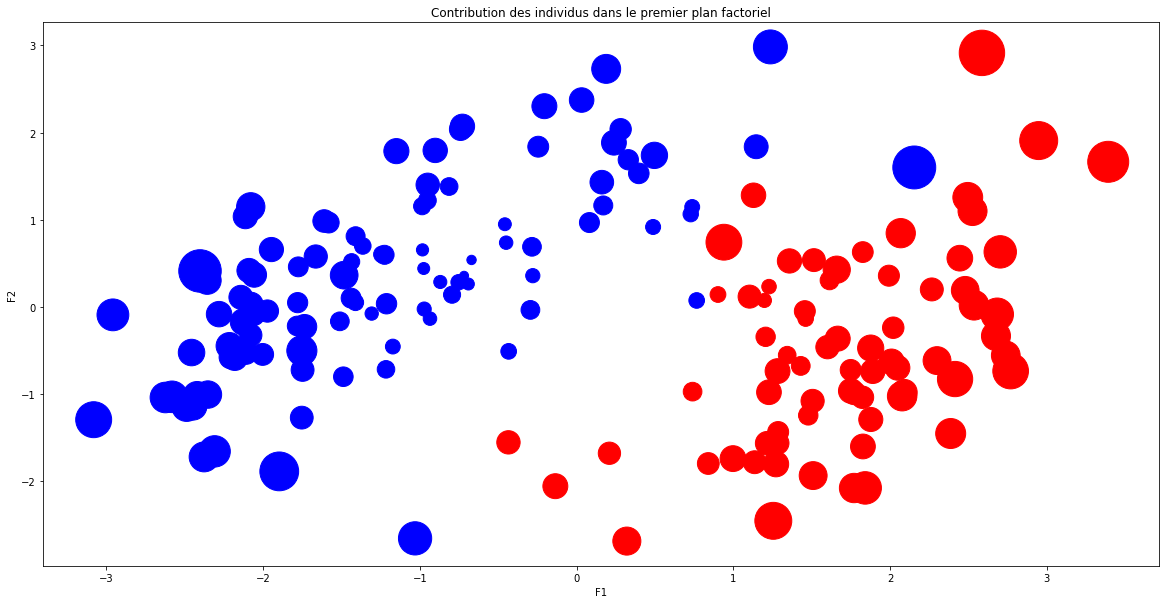

In [45]:
#Scatter Plot de la contribution des individus dans l'inertie totale
plt.figure(figsize=(20, 10))

plt.scatter(df_facto['F1'], df_facto['F2'], c=data['is_genuine'].apply(lambda x: colors[x]), 
            s=ctr_indiv_inertie['c_inertie']*100)

plt.xlabel('F1')
plt.ylabel('F2')
plt.title('Contribution des individus dans le premier plan factoriel')

plt.savefig('p6_graphic/contribution_inertie.png')
plt.show()

#### De la même manière que les individus sont représentés, ce sont ceux qui sont le plus éloignés de l'origine qui contribuent le plus dans l'inertie, et donnent ainsi un sens aux axes.

## Clustering par K-Means

C:\Users\denis\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


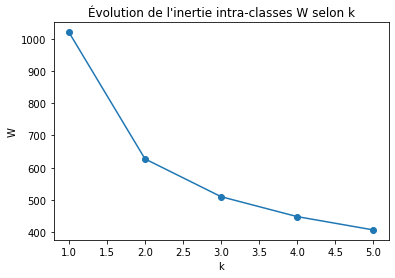

In [46]:
inerties=[]

#Boucle de 1 à 5 pour tester toutes ces possibilités
for k in range(1, 6):
    #pour chaque k, on crée un modèle et on l’ajuste
    km = cluster.KMeans(n_clusters=k, random_state=1)
    km.fit(X_scaled)
    #on stocke l’inertie associée
    inerties.append(km.inertia_)

#Visualisation des valeurs d'inertie pour chaque nombre de cluster
plt.plot(range(1, 6), inerties, marker='o')
plt.xlabel('k')
plt.ylabel('W')
plt.title("Évolution de l'inertie intra-classes W selon k")

plt.savefig("p6_graphic/kmeans_inertie.png")
plt.show()

#### Il est évident ici que k=2. En effet dans notre contexte nous souhaitons grouper les billets selon 2 possibilités, à savoir s'ils sont vrais ou faux. Ceci est d'ailleurs confirmé par la méthode du coude.

In [47]:
cls = cluster.KMeans(n_clusters=2)
cls.fit(X_scaled)

KMeans(n_clusters=2)

In [48]:
#Tableau des Centroïdes 2 clusters dans sa version centrée réduite
centroids = cls.cluster_centers_
pd.DataFrame(centroids, columns=df.columns)

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.064124,0.646532,0.720765,0.815858,0.642464,-0.877825
1,0.053092,-0.535301,-0.596763,-0.675496,-0.531933,0.726801


In [49]:
centroids_projected = pca.transform(centroids)

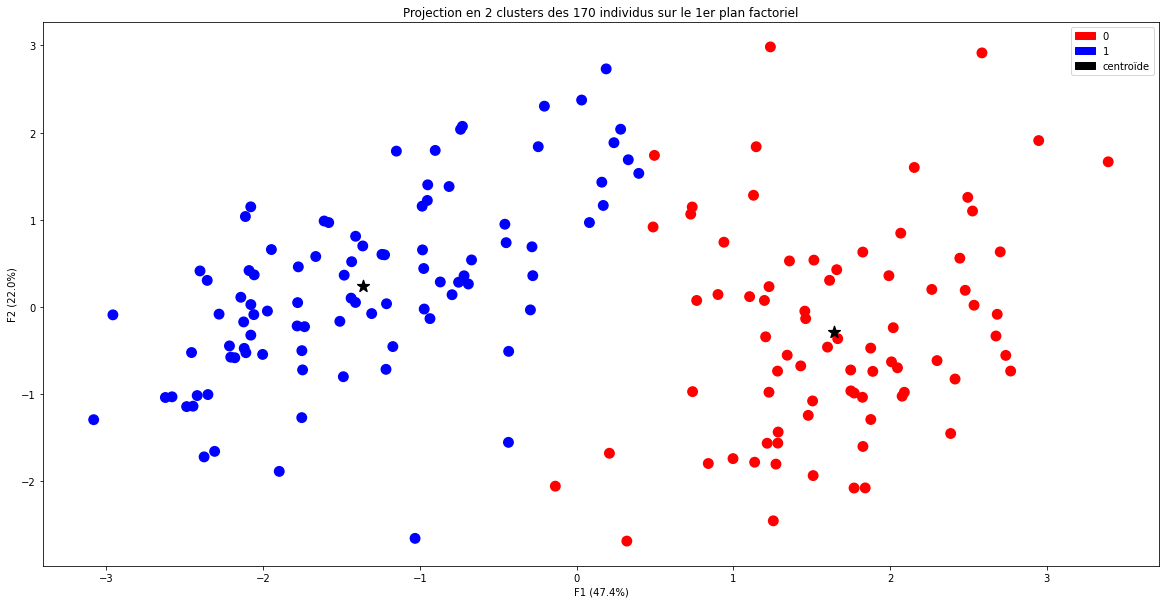

In [50]:
plt.figure(figsize=(20, 10))


colormap = np.array(['red', 'blue'])

plt.scatter(X_projected[:, 0], X_projected[:, 1], c=colormap[cls.labels_], 
           linewidths=1.4, s=90)
plt.scatter(centroids_projected[:,0],centroids_projected[:,1], marker="*", c="black",
            linewidths=1.4, s=150)
lab_0 = mpatches.Patch(color='red', label='0')
lab_1 = mpatches.Patch(color='blue', label='1')
centroïde = mpatches.Patch(color='black', hatch="*", label='centroïde')
plt.legend(handles=[lab_0, lab_1, centroïde])

plt.xlabel('F{} ({}%)'.format(1, round(scree[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(scree[1],1)))
plt.title("Projection en 2 clusters des 170 individus sur le 1er plan factoriel")

plt.savefig("p6_graphic/projection_kmeans.png")
plt.show()

In [51]:
#Intégration des clusters dans notre dataframe "df_cls" par la méthode .concat()
df_cls = pd.DataFrame(cls.fit_predict(X), columns=['cluster'])
df_cls = pd.concat([df_cls, data], axis=1)
df_cls

,cluster,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,True,171.81,104.86,104.95,4.52,2.89,112.83
1,1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,1,True,171.83,103.76,103.76,4.40,2.88,113.84
3,1,True,171.80,103.78,103.65,3.73,3.12,113.63
4,1,True,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...,...,...
165,0,False,172.11,104.23,104.45,5.24,3.58,111.78
166,0,False,173.01,104.59,104.31,5.04,3.05,110.91
167,0,False,172.47,104.27,104.10,4.88,3.33,110.68
168,0,False,171.82,103.97,103.88,4.73,3.55,111.87


In [52]:
df_cls[(df_cls.cluster==0) & (df_cls['is_genuine']==True)]

,cluster,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
69,0,True,171.94,104.11,104.16,4.08,3.35,111.76


In [53]:
df_cls[(df_cls.cluster==1) & (df_cls['is_genuine']==False)]

,cluster,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
102,1,False,171.94,104.21,104.10,4.28,3.47,112.23
118,1,False,171.83,104.39,104.17,5.51,3.33,113.64


In [54]:
#Tableau des correspondances clusters/nature billets
tableau = pd.crosstab(cls.labels_,df_cls['is_genuine'])
tableau.index = ['Cluster 0 - False','Cluster 1 - True']
tableau.columns = ['Faux','Vrais']
tableau

,Faux,Vrais
Cluster 0 - False,68,1
Cluster 1 - True,2,99


#### Le clustering apporte une classification des billets selon des variables quantitatives. Nous pouvons établir quelques caractéristiques des billets en utilisant les centroïdes, à savoir que les variables "height" et "margins" ont des centroïdes négatives pour les faux billets et inversement pour les vrais billets.Tandis que les variables "diagonal" et "lenght" ont des centroïdes positives pour les faux billets et inversement pour les vrais billets.

In [55]:
#Préparation des données
X2 = df_cls.iloc[:, 2:]
y = df_cls.iloc[:, 0]

In [140]:
y

0      1
1      1
2      1
3      1
4      1
      ..
165    0
166    0
167    0
168    0
169    0
Name: cluster, Length: 170, dtype: int32

In [139]:
X2

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.67,103.74,103.70,4.01,2.87,113.29
2,171.83,103.76,103.76,4.40,2.88,113.84
3,171.80,103.78,103.65,3.73,3.12,113.63
4,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...
165,172.11,104.23,104.45,5.24,3.58,111.78
166,173.01,104.59,104.31,5.04,3.05,110.91
167,172.47,104.27,104.10,4.88,3.33,110.68
168,171.82,103.97,103.88,4.73,3.55,111.87


In [123]:
#Séparation entre les données d'entrainement et les données test
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.20)

#### 80% des données seront utilisées pour la formation des modèles et 20% pour les tests des modèles.

In [124]:
#Instanciation d'un modèle nommé lr
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [125]:
#Sauvegarde du modèle lr 
import pickle
with open('model.pkl', 'wb') as f:
    my_pickler = pickle.Pickler(f)
    my_pickler.dump(lr)

In [126]:
from sklearn.metrics import confusion_matrix
y_pred = lr.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix) 

[[ 8  1]
 [ 1 24]]


#### Une matrice de confusion permet d'évaluer les performances d'un modèle de classification.
#### Les nombres en dehors de la diagonale indiquent les erreurs de prédiction que le modèle commet. Il y en a très peu dans notre contexte.

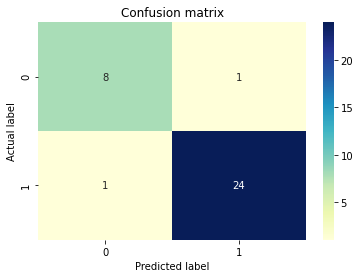

In [127]:
#Représentation graphique de la Matrice de confusion
sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')

plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.savefig("p6_graphic/confusion_matrix.png")
plt.show()

In [128]:
#Récupération de la prédiction de la valeur positive
y_prob = lr.predict_proba(X_test.values)[:,1] 
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)

In [129]:
#Mesure AUC (Area Under the Curve): Aire sous la courbe
metrics.auc(false_positive_rate, true_positive_rate)

0.991111111111111

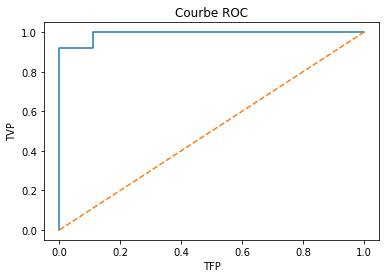

In [130]:
#Courbe ROC
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('TFP')
plt.ylabel('TVP')
plt.title('Courbe ROC')

plt.savefig("p6_graphic/courbe_roc.png")
plt.show()

In [131]:
#Autres métriques d'évaluation du modèle 
print('  - Accuracy:' +str(round(metrics.accuracy_score(y_test, y_pred)*100, 2)), '%')
print('  - Precision:' +str(round(metrics.precision_score(y_test, y_pred)*100, 2)), '%')
print('  - Recall:' +str(round(metrics.recall_score(y_test, y_pred)*100, 2)), '%')
print('  - F1 score:' +str(round(metrics.f1_score(y_test, y_pred)*100, 2)), '%')

  - Accuracy:94.12 %
  - Precision:96.0 %
  - Recall:96.0 %
  - F1 score:96.0 %


In [132]:
#Prédiction faite à partir du fichier "example.csv"
df0 = pd.read_csv('example.csv')
df0

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [133]:
#Préparation des données
X3 = df0.copy()
X3 = X3.iloc[:, :-1]

In [138]:
X3

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.76,104.01,103.54,5.21,3.30,111.42
1,171.87,104.17,104.13,6.00,3.31,112.09
2,172.00,104.58,104.29,4.99,3.39,111.57
3,172.49,104.55,104.34,4.44,3.03,113.20
4,171.65,103.63,103.56,3.77,3.16,113.33


In [134]:
#Utilisation du modèle de prédiction 'lr'
probability = lr.predict_proba(X3.values)[:, 1]

In [135]:
#Probabilités des billets établies 
proba = pd.Series(probability.round(3), name='value')

In [136]:
#Intégration des probabilités dans le jeu de données
df0_final = pd.concat([df0, proba], axis=1)
df0_final

,diagonal,height_left,height_right,margin_low,margin_up,length,id,value
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0.042
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0.020
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0.023
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,0.862
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,0.995


In [137]:
#Résultats de la classification prédictive :
resultat = []
for i in df0_final['value'] >= .5:
    if i is True :
        resultat.append('Vrai Billet')
    else :
        resultat.append('Faux Billet')

df0_final['resultat'] = resultat
df0_final

,diagonal,height_left,height_right,margin_low,margin_up,length,id,value,resultat
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0.042,Faux Billet
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0.020,Faux Billet
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0.023,Faux Billet
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,0.862,Vrai Billet
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,0.995,Vrai Billet
